# Markov Chain Monte Carlo with Couplings

## Modules importing

In [1]:
# system modules
import os
import time

# mathematical and statistical modules
import math
import numpy as np
import pandas as pd
import scipy.stats as sstat
#from mpmath import mp

# tensorflow modules
import tensorflow_probability.substrates.numpy as tfp
import tensorflow_probability.substrates.numpy.distributions as tfd
import tensorflow.random as tfr

# visualization and plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# parallelization modules 
from multiprocessing import Process, Queue, SimpleQueue

2022-01-07 12:34:03.508818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-07 12:34:03.508859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Settings and data

### Generation of data
Data are generated and placed in the variable "observations_y"; those data will be used in the likelihood function.

In [2]:
number_of_data     = 1000
observations_mean  = 43.
observations_sd    = 5 
#recall that in tfd (tfp.distributions) loc/scale convention is used, and scale in normal is the standard dev

observations_y = tfd.Normal(    
    observations_mean,
    observations_sd
    ).sample(number_of_data)

del observations_mean, observations_sd

### Likelihood functions

In [3]:
def likelihood(mu, observations_y):
    tau = 1/25 #shouldn't this be made as a parameter?
    number_of_data = len(observations_y)
    
    observation_mean = np.mean(observations_y)
    
    return np.exp(  
        -(tau/2)*( 
            number_of_data * (mu - observation_mean)**2 
            + np.sum( (observations_y - observation_mean)**2 ) 
            )  
        ) * 10000 #this coefficient is to avoid annihilation - it's a rescale

### Prior density function - setting of prior parameters

In [4]:
def pi0(mu):
    mu0 = 38.     #Set here the prior parameters
    sigma0 = 4
    return tfd.Normal(mu0,sigma0).prob(mu)

### Target distribution: posterior function
posterior proportional to likelihood times prior distribution

In [5]:
def target(mu):
    return likelihood(mu, observations_y)*pi0(mu)

### Markov chain settings
Algorithms will detect the dimensionality from the length of those arrays: please, be consistent.

In [6]:
x_start = np.array([48.])
y_start = np.array([40.])
iterations = 1000  
burnout = 100

chains_matching_tolerance = 1e-3

test_function_h = lambda x: x

## Functions

### Maximal coupling of Q
The algorithm:
1)  
    1) sample $X \sim p$
    2) sample $W|X \sim \mathcal{U}\{[0,p(X)]\}$ \
    if $W\leq q(X)$ then output $(X,X)$
2)  otherwise
    1) sample $Y^\star \sim q$
    2) sample $W^\star | Y^\star \sim \mathcal{U}\{[0, q(Y^\star)]\}$ \
    until $W^\star > p(Y^\star)$ and output $(X,Y^\star)$
   

In [7]:
def maximal_coupling(x,y): 
    
    #check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)

    #sampling of X - point 1.A
    #the new candidate is sampled from a normal centered in the given value
    x_candidate = np.random.multivariate_normal(mean=x, cov=np.eye(dimensionality), size=1)
    
    #sampling of W|X - point 1.B
    #evaluate pdf centered in x with scale 1 in x_cadidate
    pX = sstat.multivariate_normal(x,np.eye(dimensionality)).pdf(x_candidate)
    W = tfd.Uniform(0,pX).sample()
    #sampling from uniform is inside the cycle on parameters 
    
    # evaluation of qx - point 1 IF
    qX = sstat.multivariate_normal(y, np.eye(dimensionality)).pdf(x_candidate)
    
    if W < qX:
        x = x_candidate
        y = x_candidate
    else:
        while True:
            #sampling of Y* - point 2.A
            y_candidate = np.random.multivariate_normal(mean=y, cov=np.eye(dimensionality), size=1)

            #sampling of W* - point 2.B
            qY = sstat.multivariate_normal(y, np.eye(dimensionality)).pdf(y_candidate)
            W =  tfd.Uniform(0,qY).sample()

            # evaluation of py - point 2
            pY = sstat.multivariate_normal(x,np.eye(dimensionality)).pdf(y_candidate)
            if W > pY :
                break

        x = x_candidate
        y = y_candidate 


    return (x, y)

### Metropolis Hastings
The algorithm:
1) sample $(X^\star, Y^\star) | (X_t, Y_{t-1})$ from a maximal coupling of $q(X_t, \cdot)$ and $q(Y_{t-1}, \cdot)$
2) sample $U \sim \mathcal{U}([0,1])$,
3) if $$ U
 				\leq \min\bigg \{
 				1,
 				\frac{ \pi(X^\star)q(X^\star,X_t)}{
 					\pi(X_t)q(X_t, X^\star)}
 				\bigg \} $$ then $X_{t+1} = X^\star$; otherwise $X_t = X_{t-1}$;
4) if $$ U	\leq \min\bigg \{ 
 				1,
 				\frac{ \pi(Y^\star)q(Y^\star,Y_t)}{
 					\pi(Y_t)q(Y_t, Y^\star)}
 				\bigg \} $$
    then $Y_{t+1} = Y^\star$; otherwise $Y_t = Y_{t-1}$.
   

In [8]:
def metropolis_hastings(x, y, iterations):   
    # check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)
    
    
    # initializing empty np arrays
    X = np.empty([dimensionality, iterations])
    Y = np.empty([dimensionality, iterations])


    for i in range(iterations):
        # sample from maximal coupling - point 1
        (x_candidate, y_candidate) = maximal_coupling(x,y) #da qui deve uscire già multivariato
        
        # sample from a uniform - point 2
        u = tfd.Uniform(0,1).sample()
        
        # points 3 and 4 are to be executed on all the parameters which determine the dimensionality
        for param in range(dimensionality):
            # check if the sampling of X is accepted or to consider the previous - point 3
            if u == 1:                               #this to avoid zero-divisions
                x[param] = x_candidate[param]        #this to avoid zero-divisions
            elif target(x)[param] == 0:              #this to avoid zero-divisions 
                x[param] = x_candidate[param]        #this to avoid zero-divisions
            elif u < min([1., target(x_candidate)[param]/target(x)[param]]) :
                x[param] = x_candidate[param]

            X[param, i] = x[param]

            # same for Y - point 4
            if u == 1:                               #this to avoid zero-divisions
                y[param] = y_candidate[param]        #this to avoid zero-divisions
            elif target(y)[param] == 0:              #this to avoid zero-divisions 
                y[param] = y_candidate[param]        #this to avoid zero-divisions
            elif u < min([1., target(y_candidate)[param]/target(y)[param]]) :
                y[param] = y_candidate[param]

            Y[param, i] = y[param]
           
    return X, Y

### Time Averaged estimator
The algorithm:
1) draw $X_0$ and $Y_0$ from an initial distribution $\pi_0$ and draw $X_1 \sim P(X_0, \cdot)$;
2) set $t=1$: while $t<\max\{m,\tau\}$ and:
    1) draw $(X_{t+1}, Y_t)\sim \bar P \{(X_t, Y_{t-1}), \cdot \}$; 
    2) set $t \leftarrow t+1$;
3) compute the time-averaged estimator:
	$$ H_{k:m}(X,Y)
	 		= \frac{1}{m-k+1}\sum_{l=k}^{m}h(X_l) 
	 		+ \sum_{l=k+1}^{\tau -1}\min(1, \frac{l-k}{m-k+1})\{h(X_l)-h(Y_{l-1})\} .
	 		$$

In [9]:
def time_averaged_estimator(red_chain, blue_chain, iterations, burnout, meeting_time):
    #this function calculates only the formula at point 3
    
    #first addend
    first_sum = 0
    for i in range(burnout, iterations):
        first_sum += test_function_h(red_chain[i])
    
    #second addend
    second_sum = 0
    if meeting_time-1 > burnout + 1:
        for i in range(burnout + 1, meeting_time):
            # calculing the coefficient, and the min
            coef = (1-burnout)(iterations - burnout + 1)
            if coef > 1:
                coef = 1
            second_sum += coef * (test_function_h(red_chain[i])- test_function_h(blue_chain[i]))
            
    return (1/(iterations - burnout + 1))*first_sum + second_sum
    

### Parallelized operations
This function is given to each available processor

In [10]:
def parallelized_operations(x_start, y_start, iterations, burnout, chains_matching_tolerance, q_chain, q_meeting_time, q_time_averaged_estimator):
    # setting a random seed - otherwise multiprocessing has the same seed and so they end up in the same chains!
    np.random.seed(int(os.getpid() * time.time()) % 123456789 )
    tfr.set_seed(int(os.getpid() * time.time()) % 123456789 )
    
    #running metropolis hastings and obtaining two chains
    (red_chain, blue_chain) = metropolis_hastings(x_start, y_start, iterations)
    
    #get the dimensionality from one of the chains
    dimensionality = red_chain.shape[0]

    #finding the meeting time
    meeting_time = iterations + 2
    for i in range(0, iterations):
        if (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance):
            meeting_time = i
            break
    
    #checking if the chains met
    if meeting_time == iterations+2:
        print('Matching did not occurred!')
        print(meeting_time)
        return
    
    #checking if the chains met before burnout
    if meeting_time >= burnout:
        print('Meeting time occurs after burnout iterations!')
        print(meeting_time)
        return
    
    time_averaged_estimation = np.empty(dimensionality)
    
    for param in range(dimensionality):
        time_averaged_estimation[param] = time_averaged_estimator(
            red_chain[param,], 
            blue_chain[param,], 
            iterations, burnout, meeting_time
        )
    
    q_chain.put( red_chain )
    q_meeting_time.put( meeting_time )
    q_time_averaged_estimator.put( time_averaged_estimation )
    
    return

    

## Execution

### Multiprocessing settings

In [11]:
# this returns the number of available processors
num_processes = os.cpu_count()
num_processes

8

In [12]:
# this set the number of iteration, it should be a multiple of the number of available processors
num_batches_set = 16*2 #set this
num_batches = num_batches_set

In [13]:
# this initialize a shared memory between processors
# note of Queue(maxsize = 0)
q_chain = SimpleQueue()
q_meeting_time = SimpleQueue()
q_time_averaged_estimator = SimpleQueue()

### Multiprocessing execution

In [14]:
dimensionality = 1 # observations_y.shape[0]

samplings = np.empty([dimensionality, 0])
time_averaged_estimation_sum = 0
meeting_times = np.empty(0)
correct_chains = 0

while num_batches > 0:
    
    print("There are " + str(num_batches) + " left")
    
    if num_batches >= num_processes:
        current_number_processes = num_processes
    else:
        current_number_processes = num_batches
    
    processes = []
    for batch in range(current_number_processes):
        p = Process(
            target = parallelized_operations, 
            args = (x_start, y_start, 
                    iterations, burnout, 
                    chains_matching_tolerance, 
                    q_chain, q_meeting_time, q_time_averaged_estimator)
        )
        processes.append(p)

    num_batches -= current_number_processes
    
    # Starting the processes in a batch
    for p in processes:
        p.start()
        time.sleep(0.01)

    # This assures that each process in the batch is complete
    for p in processes:
        p.join()

    #unfolding queues
    while not q_chain.empty():
        red_chain = q_chain.get()
        samplings = np.append(
            samplings,
            red_chain[:,burnout :],
            axis = 1
        )

        meeting_time = q_meeting_time.get()
        time_averaged_estimation = q_time_averaged_estimator.get()
        
        if meeting_time <= burnout: #this to avoid a biased time averaged estimator
            time_averaged_estimation_sum += time_averaged_estimation
            correct_chains += 1
        
        meeting_times = np.append(
            meeting_times,
            meeting_time
        )
    
del q_chain, q_meeting_time, q_time_averaged_estimator
print('All processes are complete!')

There are 32 left
Meeting time occurs after burnout iterations!
112
There are 24 left
There are 16 left
There are 8 left
Meeting time occurs after burnout iterations!
109
Meeting time occurs after burnout iterations!
784
Matching did not occurred!
1002
All processes are complete!


### Output and plotting

In [15]:
meeting_times

array([19., 13., 11., 44., 15.,  2., 11.,  3., 25.,  8., 12., 65., 39.,
       14., 72.,  9.,  6., 35., 34.,  6.,  9.,  9., 33., 16., 17., 45.,
        3.,  9.])

In [16]:
len(meeting_times)

28

In [17]:
num_batches_set-len(meeting_times)

4

In [18]:
time_averaged_estimation_mean = time_averaged_estimation_sum/correct_chains
time_averaged_estimation_mean

array([42.94985374])

In [19]:
samplings.size

25200

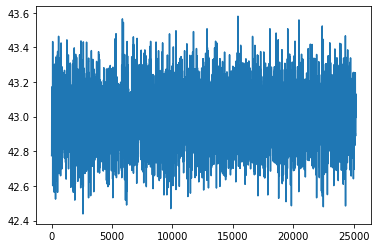

In [20]:
for param in range(samplings.shape[0]):
    plt.plot(samplings[param,:])
    plt.savefig('my_img.png')

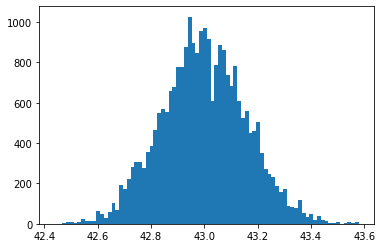

In [21]:
for param in range(samplings.shape[0]):
    plt.hist(samplings[param,:], bins = 80)
    plt.savefig('my_img_2.png')

In [22]:
samplings.shape

(1, 25200)

In [52]:
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12,4)

In [25]:
samplings[0,:]

array([42.77459527, 42.77459527, 43.16845292, ..., 42.99889883,
       42.99889883, 42.99889883])

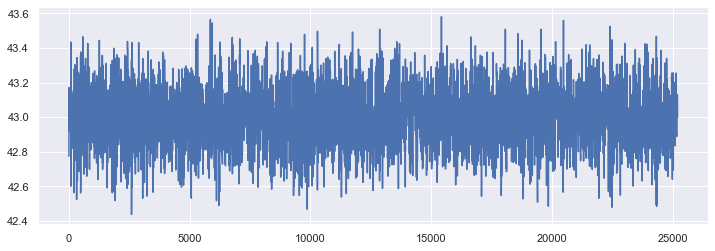

In [53]:
plt.plot(samplings[0,:])
plt.savefig('mcmc_coupling_sampling.png')

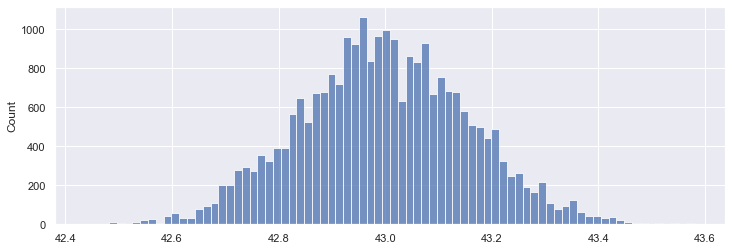

In [54]:
sns.histplot(samplings[0,:])
plt.savefig('mcmc_coupling_histogram.png')

In [34]:
(red_chain, blue_chain) = metropolis_hastings(x_start, y_start, iterations)

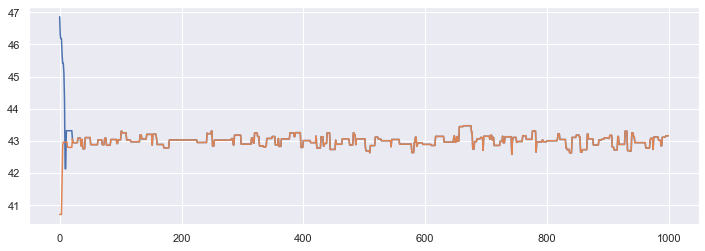

In [55]:
plt.plot(red_chain[0,:])
plt.plot(blue_chain[0,:])
plt.savefig('mcmc_coupling_chain_meeting.png')